# XAI notebook
Notebook defines way to test different CNN explainability techniques. This metric used masking and GAN to change the background of the given object in (classification) task.

In [19]:
import torch
import torchvision
import numpy as np
import cv2
from PIL import Image
from torchvision.datasets import VOCSegmentation, CIFAR10, Caltech101
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## Load datasets and pretrained networks

In [3]:
from torchvision.models import resnet34, ResNet34_Weights

# Choose model
model_name = 'ResNet'

In [4]:
if model_name == 'ResNet':
    # Import only if model used
    from torchvision.models import resnet34, ResNet34_Weights
    
    # Loads best possible pre-trained weights for ImageNet dataset (further traning needed for other datasets)
    weights = ResNet34_Weights.DEFAULT
    # Init model with weights
    model = resnet34(weights=weights)

In [5]:
if model_name == 'DenseNet':
    # Import only if model used
    from torchvision.models import densenet121, DenseNet121_Weights

    # Loads best possible pre-trained weights for ImageNet dataset (further traning needed for other datasets)
    weights = DenseNet121_Weights.DEFAULT
    # Init model with weights
    model = densenet121(weights=weights)

In [6]:
root = 'C:/Users/pette/Documents/jupterNotebooks/machinelearning/datasets'

In [7]:
transform_input = transforms.Compose([
 transforms.Resize((300,300)),
 transforms.ToTensor(),
 transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )
])
transform_output = transforms.Compose([
 transforms.Resize((300,300)),
 transforms.ToTensor(),
])


In [8]:
#voc_dataset = VOCSegmentation(root, year='2012', image_set='train', download=True, transform=transform_input, target_transform=transform_output)
#voc_original_dataset = VOCSegmentation(root, year='2012', image_set='train', download=True, transform=None, target_transform=None)
dataset = Caltech101(root, download=True, transform=transform_input, target_transform=None)
dataset_original = Caltech101(root, download=True, transform=None, target_transform=None)
#net_dataset = CIFAR10(root, train=True, download=True, transform=transform, target_transform=transform)
print(dataset[10])

Files already downloaded and verified
Files already downloaded and verified
(tensor([[[-1.8097, -1.9638, -1.9980,  ..., -1.0733, -1.0390, -1.1075],
         [-1.6555, -1.4843, -1.4329,  ..., -0.7308, -0.7308, -0.8164],
         [-1.5357, -1.3644, -1.3302,  ..., -0.7822, -0.7822, -0.8849],
         ...,
         [-1.3130, -1.1075, -1.1589,  ..., -0.5082, -0.5253, -0.6623],
         [-1.2617, -1.0562, -1.1075,  ..., -0.3369, -0.3712, -0.5082],
         [-1.5357, -1.3130, -1.3815,  ..., -0.8678, -0.8849, -1.0219]],

        [[-1.6331, -1.8256, -1.8782,  ..., -0.8277, -0.7927, -0.8627],
         [-1.4755, -1.3354, -1.3004,  ..., -0.4776, -0.4776, -0.5651],
         [-1.3529, -1.2129, -1.1954,  ..., -0.5301, -0.5301, -0.6352],
         ...,
         [-0.9328, -0.6877, -0.7402,  ..., -0.1450, -0.1625, -0.3025],
         [-0.8803, -0.6702, -0.7052,  ...,  0.0301, -0.0049, -0.1450],
         [-1.1604, -0.9328, -1.0028,  ..., -0.5126, -0.5301, -0.6702]],

        [[-1.4733, -1.6824, -1.7347,  .

In [9]:
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=4)

## Train the model
Model can be further trained with loaded datasets. All classification models pretrained weights are trained on Imagenet dataset.

In [10]:
model.eval()
image, segmentation = next(iter(data_loader))
prediction = model(image).squeeze(0).softmax(1)
class_id = prediction.argmax(dim=1)
score = prediction[[0,1,2,3],class_id]
print(class_id)
print(score)
print(segmentation)
print(segmentation)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

# GradCAM example

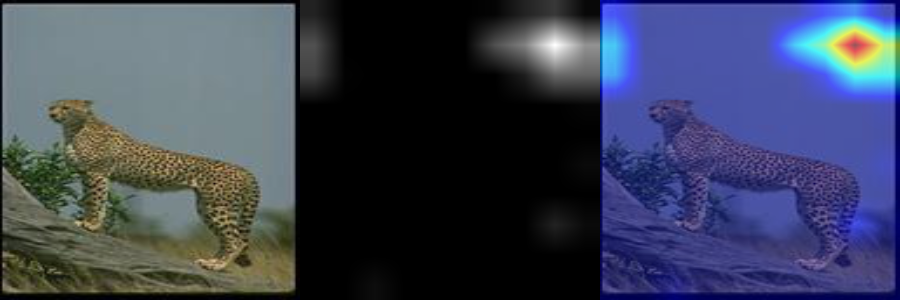

In [35]:
# Get transformed tensor with index
(input_tensor, label) = dataset[1000]
# Get original image with index and reshape(for plotting)
(img, label) = dataset_original[1000]
img = cv2.resize(np.array(img), (300, 300))
img = np.float32(img) / 255 # Assume 8 bit pixels


input_tensor = input_tensor.unsqueeze(0)

# Set target as our ground truth label
targets = [ClassifierOutputTarget(label)]
# Define target layer
target_layers = [model.layer4]

# Run model with given cam
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

# Make images the same format and plot original, greyscale and heatmap:
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [ ]:
for i, data in enumerate(data_loader):
    image, segmentation = data
    prediction